In [3]:
# https://www.tensorflow.org/tutorials/structured_data/time_series
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [4]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13568290/13568290 [==============================] - 21s 2us/step


In [5]:
df = pd.read_csv(csv_path)
# Slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

In [6]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [7]:
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

/var/folders/9g/0tl60q4d1zbb_1ggbb19w_4c0000gp/T/ipykernel_9267/637349053.py:7: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plot_features.index = date_time[:480]


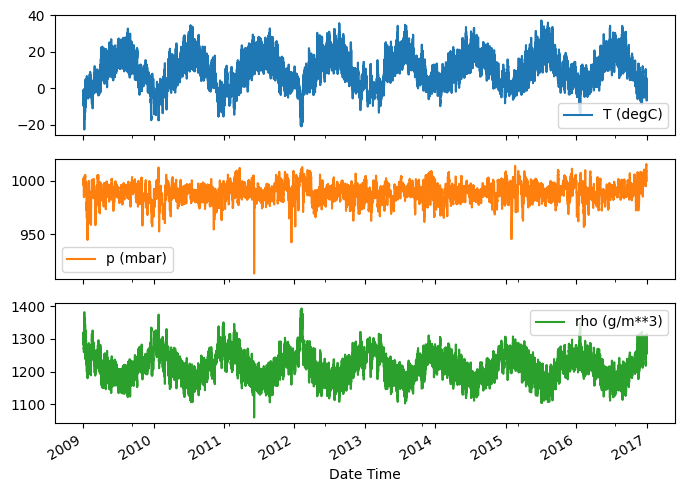

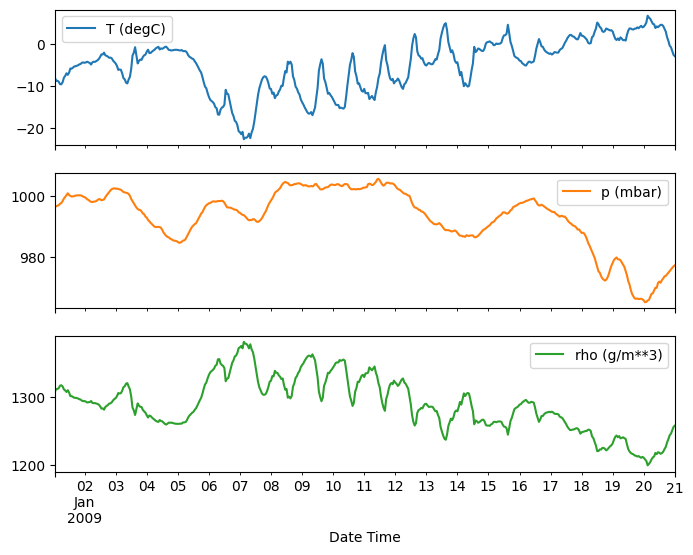

In [8]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

In [9]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame.
df['wv (m/s)'].min()

0.0

In [10]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

In [11]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

In [12]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Metal device set to: Apple M1 Pro


2023-03-04 15:39:09.102108: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-04 15:39:09.102231: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


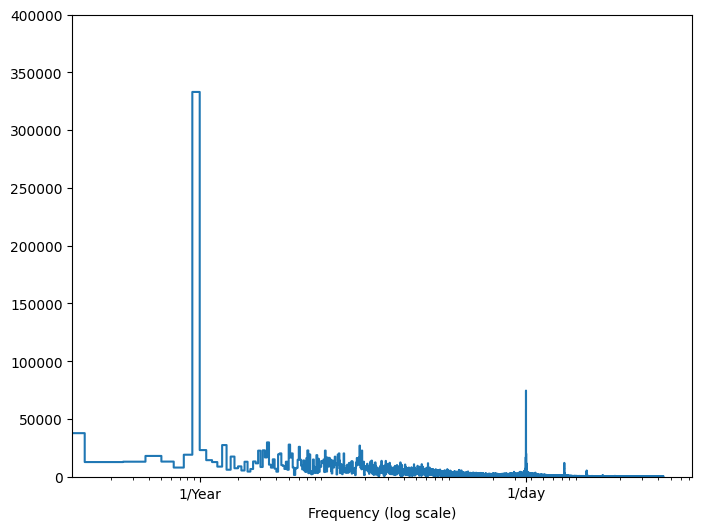

In [13]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [14]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [15]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
          self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [16]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [17]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

In [51]:
w3 = WindowGenerator(input_width=24, label_width=24, shift=1,
                     label_columns=['T (degC)'])
w3

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

In [19]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [20]:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
Labels shape: (3, 1, 1)


In [21]:
train_df[100:100+w2.total_window_size]

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
605,985.57,-1.77,272.53,-3.45,88.2,5.36,4.73,0.63,2.99,4.80,1262.78,-0.610489,-3.293904,-1.002295,-5.407902,0.965926,2.588190e-01,0.081637,0.996662
611,985.97,-1.76,272.50,-3.48,87.9,5.37,4.72,0.65,2.98,4.79,1263.25,-0.118739,-1.836165,-0.234252,-3.622434,1.000000,1.697716e-12,0.082351,0.996603
617,986.79,-2.08,272.12,-3.82,87.8,5.24,4.60,0.64,2.91,4.66,1265.86,1.277474,-0.080372,2.874317,-0.180837,0.965926,-2.588190e-01,0.083065,0.996544
623,987.67,-2.72,271.40,-4.37,88.3,5.00,4.41,0.58,2.78,4.47,1270.09,1.589997,0.003330,3.499992,0.007330,0.866025,-5.000000e-01,0.083780,0.996484
629,988.42,-3.11,270.95,-4.35,91.1,4.85,4.42,0.43,2.79,4.47,1272.89,-1.595483,-0.215718,-4.588252,-0.620356,0.707107,-7.071068e-01,0.084494,0.996424
635,989.23,-3.29,270.71,-4.55,90.9,4.79,4.35,0.44,2.74,4.40,1274.82,2.512255,0.299124,4.597526,0.547408,0.500000,-8.660254e-01,0.085208,0.996363
641,989.97,-3.53,270.41,-5.11,88.7,4.70,4.17,0.53,2.63,4.21,1276.99,4.915201,1.201833,7.654502,1.871629,0.258819,-9.659258e-01,0.085922,0.996302


In [22]:
example_inputs

<tf.Tensor: shape=(3, 6, 19), dtype=float64, numpy=
array([[[ 9.96500000e+02, -8.05000000e+00,  2.65380000e+02,
         -8.78000000e+00,  9.44000000e+01,  3.33000000e+00,
          3.14000000e+00,  1.90000000e-01,  1.96000000e+00,
          3.15000000e+00,  1.30786000e+03, -2.04862254e-01,
         -4.61677029e-02, -6.14586763e-01, -1.38503109e-01,
          2.58819045e-01,  9.65925826e-01,  1.00491198e-02,
          9.99949506e-01],
        [ 9.96620000e+02, -8.88000000e+00,  2.64540000e+02,
         -9.77000000e+00,  9.32000000e+01,  3.12000000e+00,
          2.90000000e+00,  2.10000000e-01,  1.81000000e+00,
          2.91000000e+00,  1.31225000e+03, -2.45971259e-01,
         -4.47005538e-02, -6.19847574e-01, -1.12645396e-01,
          5.00000000e-01,  8.66025404e-01,  1.07658633e-02,
          9.99942046e-01],
        [ 9.96840000e+02, -8.81000000e+00,  2.64590000e+02,
         -9.66000000e+00,  9.35000000e+01,  3.13000000e+00,
          2.93000000e+00,  2.00000000e-01,  1.83000000

In [42]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

In [43]:
test_df = np.array(w2.train_df, dtype=np.float32)

In [44]:
ds = tf.keras.utils.timeseries_dataset_from_array(
        data=test_df,
        targets=None,
        sequence_length=w2.total_window_size,
        sequence_stride=1,
        shuffle=False,
        batch_size=32,)

In [45]:
w2.train_df

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,-0.204862,-0.046168,-0.614587,-0.138503,0.258819,0.965926,0.010049,0.999950
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,-0.245971,-0.044701,-0.619848,-0.112645,0.500000,0.866025,0.010766,0.999942
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,-0.175527,0.039879,-0.614344,0.139576,0.707107,0.707107,0.011483,0.999934
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,-0.050000,-0.086603,-0.190000,-0.329090,0.866025,0.500000,0.012199,0.999926
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,-0.368202,0.156292,-0.810044,0.343843,0.965926,0.258819,0.012916,0.999917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294353,990.06,16.94,290.93,15.56,91.6,19.33,17.71,1.62,11.20,17.89,1180.85,-0.929778,-2.746910,-1.449171,-4.281390,-0.675590,0.737277,-0.546227,-0.837637
294359,990.87,16.72,290.64,14.40,86.2,19.07,16.43,2.63,10.38,16.59,1183.30,-2.254649,-1.392500,-3.165017,-1.954755,-0.461749,0.887011,-0.546827,-0.837245
294365,990.46,15.52,289.47,14.54,93.9,17.66,16.58,1.08,10.48,16.74,1187.66,-0.656072,0.616092,-0.918500,0.862529,-0.216440,0.976296,-0.547427,-0.836853
294371,990.43,15.26,289.21,14.45,94.9,17.37,16.48,0.89,10.42,16.64,1188.74,-0.565397,-0.551748,-1.259619,-1.229211,0.043619,0.999048,-0.548027,-0.836461


In [46]:
for batch in ds:
    inputs = batch
    print(inputs)

tf.Tensor(
[[[ 9.9650000e+02 -8.0500002e+00  2.6538000e+02 ...  9.6592581e-01
    1.0049120e-02  9.9994951e-01]
  [ 9.9662000e+02 -8.8800001e+00  2.6454001e+02 ...  8.6602539e-01
    1.0765864e-02  9.9994206e-01]
  [ 9.9684003e+02 -8.8100004e+00  2.6459000e+02 ...  7.0710677e-01
    1.1482601e-02  9.9993408e-01]
  ...
  [ 9.9746002e+02 -9.6300001e+00  2.6372000e+02 ...  2.5881904e-01
    1.2916059e-02  9.9991661e-01]
  [ 9.9771002e+02 -9.6700001e+00  2.6366000e+02 ...  4.3399550e-12
    1.3632778e-02  9.9990708e-01]
  [ 9.9833002e+02 -9.1700001e+00  2.6412000e+02 ... -2.5881904e-01
    1.4349490e-02  9.9989706e-01]]

 [[ 9.9662000e+02 -8.8800001e+00  2.6454001e+02 ...  8.6602539e-01
    1.0765864e-02  9.9994206e-01]
  [ 9.9684003e+02 -8.8100004e+00  2.6459000e+02 ...  7.0710677e-01
    1.1482601e-02  9.9993408e-01]
  [ 9.9698999e+02 -9.0500002e+00  2.6434000e+02 ...  5.0000000e-01
    1.2199334e-02  9.9992561e-01]
  ...
  [ 9.9771002e+02 -9.6700001e+00  2.6366000e+02 ...  4.3399550e-12

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [47]:
ds = ds.map(w2.split_window)

In [48]:
ds

<MapDataset element_spec=(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))>

In [49]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [50]:
for example_inputs, example_labels in w2.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)


In [52]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

In [58]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

In [53]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['T (degC)'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']

In [54]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [55]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


In [56]:
history = compile_and_fit(multi_step_dense, conv_window)

Epoch 1/20


2023-03-04 16:56:07.411979: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1534/1534 [==============================] - ETA: 0s - loss: 215.5579 - mean_absolute_error: 4.7075

2023-03-04 16:56:21.102257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1534/1534 [==============================] - 16s 10ms/step - loss: 215.5579 - mean_absolute_error: 4.7075 - val_loss: 2.6472 - val_mean_absolute_error: 1.2689
Epoch 2/20
1534/1534 [==============================] - 14s 9ms/step - loss: 2.0956 - mean_absolute_error: 1.1152 - val_loss: 1.5963 - val_mean_absolute_error: 0.9848
Epoch 3/20
1534/1534 [==============================] - 14s 9ms/step - loss: 1.5594 - mean_absolute_error: 0.9547 - val_loss: 2.4525 - val_mean_absolute_error: 1.2742
Epoch 4/20
1534/1534 [==============================] - 15s 10ms/step - loss: 1.3560 - mean_absolute_error: 0.8892 - val_loss: 2.2550 - val_mean_absolute_error: 1.2727


In [57]:
history

In [59]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [60]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


In [61]:
history = compile_and_fit(conv_model, conv_window)


Epoch 1/20


2023-03-04 17:01:35.692737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1534/1534 [==============================] - ETA: 0s - loss: 7.6369 - mean_absolute_error: 1.4526

2023-03-04 17:01:53.844607: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1534/1534 [==============================] - 22s 14ms/step - loss: 7.6369 - mean_absolute_error: 1.4526 - val_loss: 1.2470 - val_mean_absolute_error: 0.8673
Epoch 2/20
1534/1534 [==============================] - 20s 13ms/step - loss: 1.2122 - mean_absolute_error: 0.8322 - val_loss: 0.8559 - val_mean_absolute_error: 0.7006
Epoch 3/20
1534/1534 [==============================] - 20s 13ms/step - loss: 0.9918 - mean_absolute_error: 0.7496 - val_loss: 1.9141 - val_mean_absolute_error: 1.1665
Epoch 4/20
1534/1534 [==============================] - 20s 13ms/step - loss: 0.9030 - mean_absolute_error: 0.7116 - val_loss: 0.7544 - val_mean_absolute_error: 0.6534
Epoch 5/20
1534/1534 [==============================] - 20s 13ms/step - loss: 0.8633 - mean_absolute_error: 0.6930 - val_loss: 0.6755 - val_mean_absolute_error: 0.6040
Epoch 6/20
1534/1534 [==============================] - 20s 13ms/step - loss: 0.8474 - mean_absolute_error: 0.6877 - val_loss: 0.8031 - val_mean_absolute_error: 0.6670
Epo

In [62]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)


Wide window
Input shape: (32, 24, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)
